In [1]:
import torch
from torch import nn
import torch.optim as optim

from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

#import helper functions

torch.__version__
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(128)
device

'cuda'

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

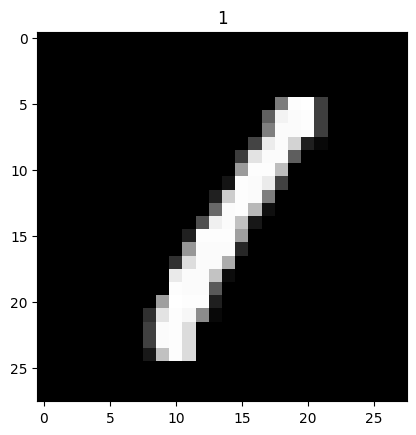

In [2]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)
img, label = train_data[3]
plt.title(label)
plt.imshow(img.squeeze(), cmap="gray")
train_data.classes

In [36]:
#Familier model, best 98.69% epoch 6
#nn.CrossEntropyLoss(),
#optim.Adam(params=model_0.parameters(), lr=0.001, weight_decay=0.001),
class digit_classifier(nn.Module):
  def __init__(self, hidden=10):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)#28/2
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)#14/2
    )
    self.output = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden*7*7, len(train_data.classes))
    )
  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    return self.output(x)
model_0 = digit_classifier(10).to(device) #Only one input channel

In [37]:
import help
import importlib
importlib.reload(help)
from help import train_step
from help import test_step
import itertools
epochs = 3
for epoch in range(epochs):
  print(f"Epoch {epoch}\n--------")
  train_step(model_0, train_dataloader,
           nn.CrossEntropyLoss(),
           optim.SGD(params=model_0.parameters(), lr=0.01, momentum=0.9),
           device)

  test_step(model_0, test_dataloader,
           nn.CrossEntropyLoss(),
           device)



Epoch 0
--------
train: 0.35381653904914856, 87.755%
test: 0.06365268677473068, 97.94329073482429%
Epoch 1
--------
train: 0.06768666207790375, 97.88333333333334%
test: 0.05150081217288971, 98.31269968051119%
Epoch 2
--------
train: 0.05208752676844597, 98.39833333333333%
test: 0.041764333844184875, 98.5423322683706%


In [9]:
torch.save(model_0.state_dict(), "model_0.pt")

In [33]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import air, tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.schedulers import HyperBandScheduler



def train_mnist(config):
    model = digit_classifier()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10): #This is iter also known as epoch, because we report on each time?
        train_step(model, train_dataloader, nn.CrossEntropyLoss(), optimizer, device)
        acc = test_step(model, test_dataloader, nn.CrossEntropyLoss(), device)

        # Send the current training result back to Tune
        tune.report(mean_accuracy=acc)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")

search_space = {
    "lr": tune.grid_search([0.01]),
    "momentum": tune.grid_search([0.3, 0.9, 0.1]),
}

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.MNIST("~/data", train=True, download=True)


tuner = tune.Tuner(
    train_mnist, param_space=search_space, 
)
results = tuner.fit()

2023-04-07 01:37:09,694	WARNING worker.py:1866 -- Warning: The actor ImplicitFunc is very large (52 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-04-07 01:37:09,816	WARNING util.py:244 -- The `start_trial` operation took 1.001 s, which may be a performance bottleneck.
2023-04-07 01:37:14,500	WARNING util.py:244 -- The `start_trial` operation took 0.574 s, which may be a performance bottleneck.


(train_mnist pid=12980) train: 1.6279590129852295, 39.82%


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_mnist_f0ef8_00000,2023-04-07_01-37-32,False,,dbd0128c68a44cf6884b81f1c6f7a1ce,red,1,93.3806,127.0.0.1,12980,19.4201,19.4201,19.4201,1680824252,0,,1,f0ef8_00000,0.00451326
train_mnist_f0ef8_00001,2023-04-07_01-37-38,False,,bd71b00d7d6f454ab7ee9f6341cf7afb,red,1,97.3442,127.0.0.1,26120,19.934,19.934,19.934,1680824258,0,,1,f0ef8_00001,0.00602436
train_mnist_f0ef8_00002,2023-04-07_01-37-39,False,,a82f65eb9c254c3fa83ef99fe0f6be78,red,1,90.9844,127.0.0.1,3372,20.0247,20.0247,20.0247,1680824259,0,,1,f0ef8_00002,0.0065155


(train_mnist pid=12980) test: 0.21717213094234467, 93.3805910543131%
(train_mnist pid=26120) train: 0.3012119233608246, 89.97833333333334%
(train_mnist pid=3372) train: 1.6881952285766602, 39.325%
(train_mnist pid=26120) test: 0.0786939412355423, 97.34424920127796%
(train_mnist pid=3372) test: 0.29183921217918396, 90.9844249201278%
(train_mnist pid=12980) train: 0.17211507260799408, 94.65666666666667%
(train_mnist pid=12980) test: 0.11269841343164444, 96.42571884984025%
(train_mnist pid=26120) train: 0.07274244725704193, 97.72166666666666%
(train_mnist pid=3372) train: 0.16754977405071259, 94.96833333333333%
(train_mnist pid=26120) test: 0.05446907505393028, 98.10303514376997%


2023-04-07 01:37:53,832	INFO tune.py:798 -- Total run time: 47.90 seconds (46.96 seconds for the tuning loop).


(train_mnist pid=3372) test: 0.10651447623968124, 96.63538338658147%


In [22]:
results.get_best_result(metric="mean_accuracy",mode="max")

{'lr': 0.01, 'momentum': 0.9}